## Can we get data near the [Coastal Endurance](http://oceanobservatories.org/array/coastal-endurance/) array?

This notebook uses a searches the csw NGDC catalog filtering the results with:
- (a) bounding box for the Coastal Endurance array;
- (b) time span of "today &plusmn; 5 days";
- (c) variable: temperature

![](http://oceanobservatories.org/wp-content/uploads/2011/04/Endurance-Array-Map_2013_04-17_ver_0-02.jpg)

ioos-tools package: https://github.com/pyoceans/ioos_tools

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import folium
from folium import IFrame

# First step: create the filter

In [2]:
from owslib import fes

(a) Bounding box: everything inside the dashed lines from the map above

In [3]:
min_lon, max_lon = -127, -123.75
min_lat, max_lat = 43, 48

bbox = [min_lon, min_lat, max_lon, max_lat]
crs = 'urn:ogc:def:crs:OGC:1.3:CRS84'

bbox_crs = fes.BBox(bbox, crs=crs)

(b) Time span: today ±5 days.

In [4]:
from datetime import datetime, timedelta


dt = 5

date = datetime.utcnow()
start = date - timedelta(days=dt)
stop = date + timedelta(days=dt)

from ioos_tools.ioos import fes_date_filter


begin, end = fes_date_filter(start, stop)

(c) Variable: `sea_water_temperature`.

(All names in `name_list` are [CF standard names](http://cfconventions.org/standard-names.html),
but we can uses non-CF like 'Water Temperature' and that will return more datasets.)

In [5]:
sos_name = 'sea_water_temperature'

# NOTE: I added 'Water Temperature' to test for including NDBC endpoints
cf_names = [
    'sea_water_temperature',
    'sea_surface_temperature',
    'sea_water_potential_temperature',
    'equivalent_potential_temperature',
    'sea_water_conservative_temperature',
    'pseudo_equivalent_potential_temperature',
]

# test to try to yield NDBC results
# cf_names = ['temp', 'sea_water_temperature']
# cf_names = ['stonewall', 'elizabeth']


kw = dict(
    wildCard='*',
    escapeChar='\\',
    singleChar='?',
    propertyname='apiso:AnyText'
)

or_filt = fes.Or(
    [fes.PropertyIsLike(literal=('*%s*' % val), **kw)
        for val in cf_names])

Assemble the `fes` filter with `a`+`b`+`c`.

EXCLUDING THE TEMPORAL FILTERS (begin, end) AND DELIBERATELY LOOKING FOR NDBC BUOY NAMES WAS SUCCESSFUL IN PRODUCING NDBC RESULTS

In [6]:
filter_list = [
    fes.And(
        [
            bbox_crs,
            begin, end,
            or_filt,
            fes.Not([fes.PropertyIsLike(literal='*cdip*', **kw)]),
            fes.Not([fes.PropertyIsLike(literal='*grib*', **kw)]),
        ]
    )
]

In [7]:
from owslib.csw import CatalogueServiceWeb
from ioos_tools.ioos import get_csw_records


endpoint = 'https://data.ioos.us/csw'

csw = CatalogueServiceWeb(endpoint, timeout=60)

# get_csw_records(csw, filter_list, pagesize=10, maxrecords=1000)
get_csw_records(csw, filter_list, pagesize=10, maxrecords=1000, esn='full')

records = '\n'.join(csw.records.keys())
print('Found {} records.\n'.format(len(csw.records.keys())))

Found 28 records.



All the records found:

In [8]:
for key, value in list(csw.records.items()):
    print(u'[{}]\n  {}'.format(value.title, key))

[urn:ioos:station:NOAA.NOS.CO-OPS:9432780 station, Charleston, OR]
  opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_9432780
[urn:ioos:station:NOAA.NOS.CO-OPS:9435380 station, South Beach, OR]
  opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_9435380
[urn:ioos:station:NOAA.NOS.CO-OPS:9437540 station, Garibaldi, OR]
  opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_9437540
[urn:ioos:station:NOAA.NOS.CO-OPS:9439040 station, Astoria, OR]
  opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_9439040
[urn:ioos:station:NOAA.NOS.CO-OPS:9440581 station, Cape Disappointment]
  opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_9440581
[urn:ioos:station:NOAA.NOS.CO-OPS:9440910 station, Toke Point, WA]
  opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_9440910
[urn:ioos:station:NOAA.NOS.CO-OPS:9441102 station, Westport, WA]
  opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_9441102
[urn:ioos:station:NOAA.NOS.CO-OPS:

In [9]:
#cswrec1 = csw.records['data.nanoos.org-urn_ioos_station_nanoos_osu_cb06']
cswrec1 = csw.records['opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_9435380']
#cswrec1 = csw.records['sdf.ndbc.noaa.gov-urn_ioos_station_wmo_46050']
#['(OSU) CB-06, 6NM W of Coos Bay']

In [10]:
rec_allattrs = set(cswrec1.__dict__.keys())
print(rec_allattrs)

{'title', 'created', 'accessrights', 'abstract', 'format', 'source', 'modified', 'ispartof', 'xml', 'bbox', 'temporal', 'spatial', 'language', 'subjects', 'references', 'creator', 'bbox_wgs84', 'rights', 'identifiers', 'type', 'uris', 'identifier', 'date', 'alternative', 'relation', 'contributor', 'rightsholder', 'license', 'publisher', 'coverage', 'rdf', 'issued'}


In [11]:
rec_emptyattrs = {k for k,v in cswrec1.__dict__.items() if v is None}

In [12]:
print(rec_allattrs.difference(rec_emptyattrs))

{'identifiers', 'type', 'title', 'language', 'subjects', 'references', 'uris', 'identifier', 'abstract', 'date', 'modified', 'rdf', 'xml', 'bbox', 'rights'}


But note that these additional attributes are also effectively empty: `rdf`, `rights`, `type`, `uris`.  
`type` is "dataset", so it doesn't add much. And `xml` presumably has already been parsed into the other attributes, so it has no additional, useful info. That leaves these attributes having useful, distinct info:

In [13]:
print(rec_allattrs.difference(rec_emptyattrs).difference(set(['rdf', 'rights', 'type', 'uris', 'type', 'xml'])))

{'identifiers', 'title', 'language', 'subjects', 'references', 'identifier', 'abstract', 'date', 'modified', 'bbox'}


In [14]:
len(cswrec1.references), cswrec1.references

(13,
 [{'scheme': 'South Beach',
   'url': 'https://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?request=DescribeSensor&outputFormat=text/xml; subtype="sensorML/1.0.1/profiles/ioos_sos/1.0"&version=1.0.0&service=SOS&procedure=urn:ioos:station:NOAA.NOS.CO-OPS:9435380'},
  {'scheme': 'WWW:LINK - text/csv',
   'url': 'http://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?offering=urn:ioos:station:NOAA.NOS.CO-OPS:9435380&service=SOS&observedProperty=http://mmisw.org/ont/cf/parameter/air_pressure&request=GetObservation&responseFormat=text/csv&version=1.0.0&eventTime=2018-07-29T16:18:49/2018-07-29T18:18:49'},
  {'scheme': 'WWW:LINK - text/csv',
   'url': 'http://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?offering=urn:ioos:station:NOAA.NOS.CO-OPS:9435380&service=SOS&observedProperty=http://mmisw.org/ont/cf/parameter/air_temperature&request=GetObservation&responseFormat=text/csv&version=1.0.0&eventTime=2018-07-29T16:18:49/2018-07-29T18:18:49'},
  {'scheme': 'WWW:LINK - text/csv',
   'url': 'ht

We can use `geolinks.sniff_link`  to find more information about the services available.

In [15]:
# pretty print xml
import xml.dom.minidom

cswrec1_parsedxml = xml.dom.minidom.parseString(cswrec1.xml)
print(cswrec1_parsedxml.toprettyxml(indent='    '))

<?xml version="1.0" ?>
<csw:Record xmlns:apiso="http://www.opengis.net/cat/csw/apiso/1.0" xmlns:atom="http://www.w3.org/2005/Atom" xmlns:csw="http://www.opengis.net/cat/csw/2.0.2" xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:dct="http://purl.org/dc/terms/" xmlns:dif="http://gcmd.gsfc.nasa.gov/Aboutus/xml/dif/" xmlns:fgdc="http://www.opengis.net/cat/csw/csdgm" xmlns:gco="http://www.isotc211.org/2005/gco" xmlns:gmd="http://www.isotc211.org/2005/gmd" xmlns:gml="http://www.opengis.net/gml" xmlns:inspire_common="http://inspire.ec.europa.eu/schemas/common/1.0" xmlns:inspire_ds="http://inspire.ec.europa.eu/schemas/inspire_ds/1.0" xmlns:ogc="http://www.opengis.net/ogc" xmlns:os="http://a9.com/-/spec/opensearch/1.1/" xmlns:ows="http://www.opengis.net/ows" xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#" xmlns:sitemap="http://www.sitemaps.org/schemas/sitemap/0.9" xmlns:soapenv="http://www.w3.org/2003/05/soap-envelope" xmlns:srv="http://www.isotc211.org/2005/srv" xmlns:xlink="http://w

In [16]:
from geolinks import sniff_link


df = []
for key, rec in csw.records.items():
    df.append(pd.DataFrame(rec.references))

df = pd.concat(df, ignore_index=True)
df['geolink'] = [sniff_link(url) for url in df['url']]

All the schemes in the list.

In [17]:
df['scheme'].value_counts()

WWW:LINK - text/xml                                            120
WWW:LINK - application/json                                    120
WWW:LINK - text/csv                                             53
WWW:LINK                                                        43
Open Geospatial Consortium Sensor Observation Service (SOS)     13
OGC:SOS                                                          8
http                                                             6
None                                                             5
South Slough Reserve                                             5
OPeNDAP:OPeNDAP                                                  5
OGC:SOS:DescribeSensor                                           5
OGC:WCS                                                          4
UNIDATA:NCSS                                                     4
OGC:WMS                                                          4
ERDDAP:griddap                                                

The services found using `geolinks`:

In [18]:
df['geolink'].value_counts()

OGC:SOS            335
WWW:LINK             6
OGC:WMS              6
OPeNDAP:OPeNDAP      5
OGC:WCS              4
UNIDATA:NCSS         4
Name: geolink, dtype: int64

In [19]:
df.loc[df['scheme'] == 'OGC:SOS', 'url'].value_counts()

http://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?request=GetCapabilities&acceptVersions=1.0.0&service=SOS    8
Name: url, dtype: int64

However, we can also "hack" all the SOS URLs returned to get only those with the variable of interest, format, and `GetObservation` to download the data. We only need to correct the dates on the URLs b/c the `csw` ones are for 1-day only.

In [20]:
df.loc[df['scheme'] == 'Open Geospatial Consortium Sensor Observation Service (SOS)', 'url'].value_counts()

http://data.nanoos.org/52nsos/sos/kvp?acceptVersions=1.0.0&request=GetCapabilities&service=SOS    13
Name: url, dtype: int64

In [21]:
df.loc[df['geolink'] == 'OPeNDAP:OPeNDAP', 'url'].value_counts()

https://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/images/tide_gauge.jpg                          3
http://ingria.coas.oregonstate.edu/opendap/hyrax/aggregated/ocean_time_aggregation.ncml         1
http://ingria.coas.oregonstate.edu/opendap/hyrax/aggregated/ocean_time_aggregation.ncml.html    1
Name: url, dtype: int64

In [22]:
df.loc[df['scheme'] == 'OPeNDAP:OPeNDAP', 'url'].value_counts()

http://thredds.cencoos.org/thredds/dodsC/AOOS_OSTIA.nc                                          1
http://oos.soest.hawaii.edu/thredds/dodsC/pacioos/hycom/global                                  1
http://oos.soest.hawaii.edu/thredds/dodsC/hioos/satellite/dhw_5km                               1
http://thredds.secoora.org/thredds/dodsC/G1_SST_GLOBAL.nc                                       1
http://ingria.coas.oregonstate.edu/opendap/hyrax/aggregated/ocean_time_aggregation.ncml.html    1
Name: url, dtype: int64

In [23]:
df.loc[df['scheme'] == 'None', 'url'].value_counts()

http://ona.coas.oregonstate.edu:8080/thredds/dodsC/NANOOS/OCOS                                                    1
http://amb6400b.stccmop.org:8080/thredds/dodsC/model_data/forecast                                                1
http://ona.coas.oregonstate.edu:8080/thredds/wms/NANOOS/OCOS?service=WMS&version=1.3.0&request=GetCapabilities    1
http://ingria.coas.oregonstate.edu/opendap/hyrax/aggregated/ocean_time_aggregation.ncml                           1
http://amb6400b.stccmop.org:8080/ncWMS2/wms?service=WMS&version=1.3.0&request=GetCapabilities                     1
Name: url, dtype: int64

Careful below, the results of "size" are not directly comparable to the results from `value_counts` shown above.

In [24]:
df.groupby(['geolink', 'scheme']).size()

geolink          scheme                                                     
OGC:SOS          6NM W of Coos Bay                                                1
                 Astoria                                                          1
                 Cape Disappointment                                              1
                 Charleston                                                       1
                 Garibaldi                                                        1
                 La Push                                                          1
                 OGC:SOS                                                          8
                 OGC:SOS:DescribeSensor                                           5
                 Open Geospatial Consortium Sensor Observation Service (SOS)     13
                 South Beach                                                      1
                 South Slough Reserve                                             5

We can get the canonical URL for SOS.

In [25]:
def fix_series(url, start, stop):
    split = url.split('&')
    new_url = []
    for line in split:
        if line.startswith('eventTime='):
            line = f'eventTime={start:%Y-%m-%dT%H:%m:00}/{stop:%Y-%m-%dT%H:%m:00}'
        new_url.append(line)

    return '&'.join(new_url)

In [26]:
sos_urls = [
    fix_series(url, start, stop) for url in df.loc[df['geolink'] == 'OGC:SOS', 'url']
    if 'GetObservation' in url and 'text/csv' in url and sos_name in url
]

len(sos_urls)

7

In [27]:
observations = []
for url in sos_urls:
    observations.append(
        pd.read_csv(url, index_col='date_time', parse_dates=True)
    )

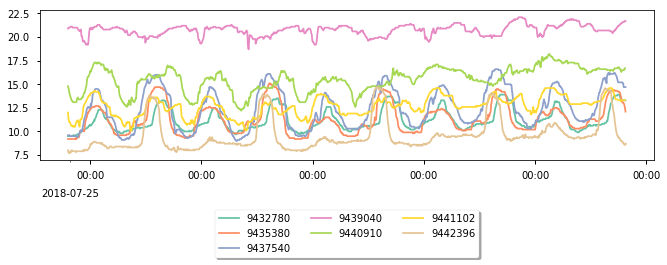

In [28]:
from itertools import cycle


def mpl_palette(cmap, n_colors=6):
    brewer_qual_pals = {"Accent": 8, "Dark2": 8, "Paired": 12,
                        "Pastel1": 9, "Pastel2": 8,
                        "Set1": 9, "Set2": 8, "Set3": 12}

    if cmap.name in brewer_qual_pals:
        bins = np.linspace(0, 1, brewer_qual_pals[cmap.name])[:n_colors]
    else:
        bins = np.linspace(0, 1, n_colors + 2)[1:-1]
    palette = list(map(tuple, cmap(bins)[:, :3]))

    pal_cycle = cycle(palette)
    palette = [next(pal_cycle) for _ in range(n_colors)]
    
    return palette

with mpl.style.context('seaborn-notebook'):
    fig, ax = plt.subplots(figsize=(11, 2.75))
    colors = mpl_palette(plt.cm.Set2, n_colors=len(observations))
    for k, series in enumerate(observations):
        station_name = series['station_id'].iloc[0].split(':')[-1]
        ax.plot(series.index, series['sea_water_temperature (C)'], label=station_name, color=colors[k])
    leg = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),
              ncol=3, fancybox=True, shadow=True)

hours = mpl.dates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(hours)

days = mpl.dates.DateFormatter('\n\n%Y-%m-%d')
ax.xaxis.set_minor_formatter(days)
ax.xaxis.set_minor_locator(mpl.ticker.FixedLocator([mpl.dates.date2num(start)]))

fig.savefig('time_series.png', bbox_extra_artists=(leg,),
            bbox_inches='tight', dpi=150)

The `scheme` information and `geolinks` for `OPeNDAP` are not very consistent.

In [29]:
set(df.loc[df['scheme'] == 'OPeNDAP:OPeNDAP', 'url'])

{'http://ingria.coas.oregonstate.edu/opendap/hyrax/aggregated/ocean_time_aggregation.ncml.html',
 'http://oos.soest.hawaii.edu/thredds/dodsC/hioos/satellite/dhw_5km',
 'http://oos.soest.hawaii.edu/thredds/dodsC/pacioos/hycom/global',
 'http://thredds.cencoos.org/thredds/dodsC/AOOS_OSTIA.nc',
 'http://thredds.secoora.org/thredds/dodsC/G1_SST_GLOBAL.nc'}

In [30]:
set(df.loc[df['geolink'] == 'OPeNDAP:OPeNDAP', 'url'])

{'http://ingria.coas.oregonstate.edu/opendap/hyrax/aggregated/ocean_time_aggregation.ncml',
 'http://ingria.coas.oregonstate.edu/opendap/hyrax/aggregated/ocean_time_aggregation.ncml.html',
 'https://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/images/tide_gauge.jpg'}

It seems that using `geolinks` we not only lost 4 URLs but we got a wrong one with the `jpeg` image of the a station and a duplicated one. So let's use the `scheme` instead. We need to clean those that end with `.html` to pass them to the `OPeNDAP` clients.

In [31]:
dap_urls = []

for url in set(df.loc[df['scheme'] == 'OPeNDAP:OPeNDAP', 'url']):
    if url.endswith('.html'):
        url = url.replace('.html', '')
    dap_urls.append(url)

In [32]:
dap_urls

['http://ingria.coas.oregonstate.edu/opendap/hyrax/aggregated/ocean_time_aggregation.ncml',
 'http://thredds.secoora.org/thredds/dodsC/G1_SST_GLOBAL.nc',
 'http://oos.soest.hawaii.edu/thredds/dodsC/hioos/satellite/dhw_5km',
 'http://oos.soest.hawaii.edu/thredds/dodsC/pacioos/hycom/global',
 'http://thredds.cencoos.org/thredds/dodsC/AOOS_OSTIA.nc']

Finally the numerical models grid outline.

In [33]:
# from netCDF4 import Dataset
# import gridgeo


# url = 'http://ingria.coas.oregonstate.edu/opendap/hyrax/aggregated/ocean_time_aggregation.ncml'
# nc = Dataset(url)

# grid = gridgeo.GridGeo(
#     nc,
#     standard_name='sea_water_potential_temperature',
# )

In [34]:
tiles = 'http://services.arcgisonline.com/arcgis/rest/services/Ocean/World_Ocean_Base/MapServer/tile/{z}/{y}/{x}'

m = folium.Map(
    tiles=tiles,
    attr='ESRI'
)

#gj = folium.GeoJson(grid.outline.__geo_interface__)
#folium.Popup(getattr(nc, 'summary', url)).add_to(gj)
#gj.add_to(m)

In [35]:
from bokeh.plotting import figure
from bokeh.resources import CDN
from bokeh.embed import file_html


def make_marker(series):
    width, height = 500, 250

    station = series['station_id'].iloc[0].split(':')[-1]
    lat = series['latitude (degree)'].iloc[0]
    lon = series['longitude (degree)'].iloc[0]

    p = figure(
        x_axis_type='datetime',
        title=station,
        width=width, height=height)
    p.line(series.index, series['sea_water_temperature (C)'], line_width=2)
    html = file_html(p, CDN, station)
    iframe = IFrame(html, width=width+40, height=height+80)
    
    popup = folium.Popup(iframe, max_width=2650)
    icon = folium.Icon(color='green', icon='stats')
    marker = folium.Marker(
        location=[lat, lon],
        popup=popup,
        icon=icon
    )
    return marker

for series in observations:
    make_marker(series).add_to(m)

Display the region bounding box and Endurance array lines.

In [36]:
oregon_line = [[44+35/60., -125], [44+35/60., -123.75]]
washington_line = [[47, -125], [47, -123.75]]

color = 'orange'

box = [[bbox[1], bbox[0]], [bbox[1], bbox[2]],
       [bbox[3], bbox[2]], [bbox[3], bbox[0]],
       [bbox[1], bbox[0]]]

folium.PolyLine(box, color='red').add_to(m)

folium.PolyLine(
    oregon_line,
    color=color,
    popup='Oregon Line'
).add_to(m)

folium.PolyLine(
    washington_line,
    color=color,
    popup='Washington Line'
).add_to(m);

In [37]:
m.fit_bounds(m.get_bounds())

m